## Notebook for ELG failure rate exploration

In [1]:
import numpy as np
import fitsio
from matplotlib import pyplot as plt
import os
from astropy.table import Table,join,unique
from scipy.special import erf
from desitarget.sv3 import sv3_targetmask

In [2]:
arz = Table.read('/global/homes/r/raichoor/sv3/sv3-elg-daily-thru20210420.fits')

In [3]:
wg = arz['FIBERSTATUS'] == 0
arz = arz[wg]

In [4]:
#combine info together to get Anand's criteria for selecting good redshifts
arz['o2c'] = np.log10(arz['FOII']/arz['FOII_ERR'])+0.2*np.log10(arz['DELTACHI2']) 

<ipython-input-4-a0bbde62e718>:2: RuntimeWarning: invalid value encountered in true_divide
  arz['o2c'] = np.log10(arz['FOII']/arz['FOII_ERR'])+0.2*np.log10(arz['DELTACHI2'])
<ipython-input-4-a0bbde62e718>:2: RuntimeWarning: divide by zero encountered in log10
  arz['o2c'] = np.log10(arz['FOII']/arz['FOII_ERR'])+0.2*np.log10(arz['DELTACHI2'])
<ipython-input-4-a0bbde62e718>:2: RuntimeWarning: invalid value encountered in log10
  arz['o2c'] = np.log10(arz['FOII']/arz['FOII_ERR'])+0.2*np.log10(arz['DELTACHI2'])


In [5]:
#assign nans a low value that will get cut
w = (arz['o2c']*0) != 0
arz['o2c'][w] = -20

<ipython-input-5-d2b8565b2677>:2: RuntimeWarning: invalid value encountered in multiply
  w = (arz['o2c']*0) != 0


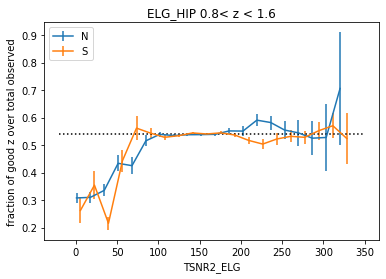

In [6]:
zmin = 0.8
zmax = 1.6
for ps in ['N','S']:
    wgh = (arz['o2c'] > 0.9) | ((arz['ZWARN'] == 0) & (arz['Z'] > 1.55))
    #wa = arz['LOCATION_ASSIGNED'] == 1
    wa = arz['TSNR2_ELG'] != 1e20
    wa &= arz['TSNR2_ELG'] != -99.0
    wa &= arz['PHOTSYS'] == ps
    wgh &= wa
    wgh &= arz['Z'] > zmin
    wgh &= arz['Z'] < zmax
    ffo = arz[wa]
    ffz = arz[wgh]
    a = np.histogram(ffz['TSNR2_ELG'],bins=20)
    b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
    #plt.clf()
    plt.errorbar(a[1][:-1],a[0]/b[0],np.sqrt(a[0])/b[0],label=ps)#,fmt='ko')
vs = np.arange(-20,350,1)
ol = np.ones(len(vs))*0.54
plt.plot(vs,ol,'k:')
plt.title('ELG_HIP '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_ELG')
plt.ylabel('fraction of good z over total observed')
plt.legend(loc='upper left')
plt.show()   

### surprisingly constant above ~ 100, pretty similar in N/S

### combining N/S, selecting to HIP and removing QSO

20.053578678650858


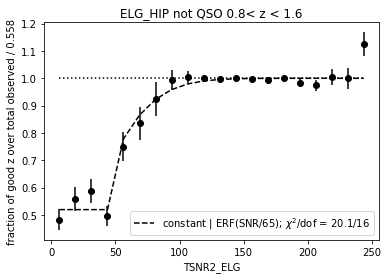

In [7]:
zmin = 0.8
zmax = 1.6
wgh = (arz['o2c'] > 0.9) | ((arz['ZWARN'] == 0) & (arz['Z'] > 1.55))
wa = arz['TSNR2_ELG'] != 1e20
wa &= arz['TSNR2_ELG'] != -99.0
wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['QSO']) == 0)
wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['ELG_HIP']) > 0)
wgh &= wa
wgh &= arz['Z'] > zmin
wgh &= arz['Z'] < zmax
ffo = arz[wa]
ffz = arz[wgh]
a = np.histogram(ffz['TSNR2_ELG'],bins=20,range=(0,250))
b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
fr = 0.558
ds = a[0]/b[0]/fr
es = np.sqrt(a[0])/b[0]/fr
bs = 250/20
plt.errorbar(a[1][:-1]+bs/2.,ds,es,fmt='ko')#,label=ps)#,fmt='ko')
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
el = erf(vs/65)
wl = vs < 45
lm = 0.52
el[wl] = lm
chi2 = np.sum(((ds-el)/es)**2.)
print(chi2)
plt.plot(vs,el,'k--',label='constant | ERF(SNR/65); $\chi^2$/dof = '+str(round(chi2,1))+'/16')
plt.plot(vs,ol,'k:')
plt.title('ELG_HIP not QSO '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_ELG')
plt.ylabel('fraction of good z over total observed / '+str(fr))
plt.legend(loc='lower right')
plt.show() 

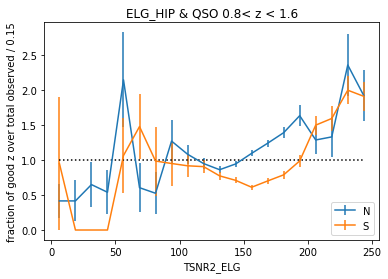

In [8]:
zmin = 0.8
zmax = 1.6
for ps in ['N','S']:
    wgh = (arz['o2c'] > 0.9) | ((arz['ZWARN'] == 0) & (arz['Z'] > 1.55))
    wa = arz['TSNR2_ELG'] != 1e20
    wa &= arz['TSNR2_ELG'] != -99.0
    wa &= arz['PHOTSYS'] == ps
    wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['QSO']) > 0)
    wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['ELG_HIP']) > 0)
    wgh &= wa
    wgh &= arz['Z'] > zmin
    wgh &= arz['Z'] < zmax
    ffo = arz[wa]
    ffz = arz[wgh]
    a = np.histogram(ffz['TSNR2_ELG'],bins=20,range=(0,250))
    b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
    fr = 0.15
    ds = a[0]/b[0]/fr
    es = np.sqrt(a[0])/b[0]/fr
    bs = 250/20
    plt.errorbar(a[1][:-1]+bs/2.,ds,es,label=ps)#,fmt='ko')
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
el = erf(vs/65)
wl = vs < 45
el[wl] = 0.52
plt.plot(vs,ol,'k:')
plt.title('ELG_HIP & QSO '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_ELG')
plt.ylabel('fraction of good z over total observed / '+str(fr))
plt.legend(loc='lower right')
plt.show() 

### quasar targets are obviously quite different from non-quasars!

## see how things vary in redshift bins, keep ERF part constant (i.e., how bad would things be if we just have one model in the whole range)

25.478454057290666


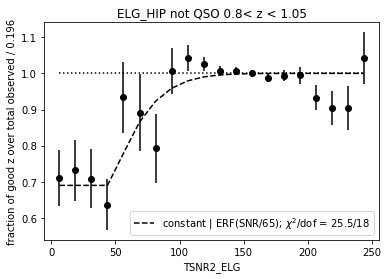

In [13]:
zmin = 0.8
zmax = 1.05
wgh = (arz['o2c'] > 0.9) | ((arz['ZWARN'] == 0) & (arz['Z'] > 1.55))
wa = arz['TSNR2_ELG'] != 1e20
wa &= arz['TSNR2_ELG'] != -99.0
wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['QSO']) == 0)
wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['ELG_HIP']) > 0)
wgh &= wa
wgh &= arz['Z'] > zmin
wgh &= arz['Z'] < zmax
ffo = arz[wa]
ffz = arz[wgh]
a = np.histogram(ffz['TSNR2_ELG'],bins=20,range=(0,250))
b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
fr = 0.196
ds = a[0]/b[0]/fr
es = np.sqrt(a[0])/b[0]/fr
bs = 250/20
plt.errorbar(a[1][:-1]+bs/2.,ds,es,fmt='ko')#,label=ps)#,fmt='ko')
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
el = erf(vs/65)
wl = vs < 45
lm = 0.69
el[wl] = lm
chi2 = np.sum(((ds-el)/es)**2.)
print(chi2)
plt.plot(vs,el,'k--',label='constant | ERF(SNR/65); $\chi^2$/dof = '+str(round(chi2,1))+'/18')
plt.plot(vs,ol,'k:')
plt.title('ELG_HIP not QSO '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_ELG')
plt.ylabel('fraction of good z over total observed / '+str(fr))
plt.legend(loc='lower right')
plt.show() 

25.32663860295442


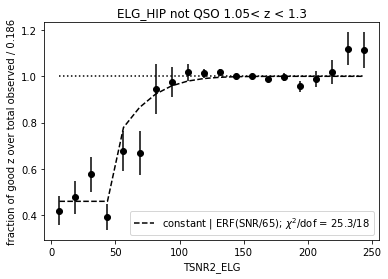

In [14]:
zmin = 1.05
zmax = 1.3
wgh = (arz['o2c'] > 0.9) | ((arz['ZWARN'] == 0) & (arz['Z'] > 1.55))
wa = arz['TSNR2_ELG'] != 1e20
wa &= arz['TSNR2_ELG'] != -99.0
wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['QSO']) == 0)
wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['ELG_HIP']) > 0)
wgh &= wa
wgh &= arz['Z'] > zmin
wgh &= arz['Z'] < zmax
ffo = arz[wa]
ffz = arz[wgh]
a = np.histogram(ffz['TSNR2_ELG'],bins=20,range=(0,250))
b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
fr = 0.186
ds = a[0]/b[0]/fr
es = np.sqrt(a[0])/b[0]/fr
bs = 250/20
plt.errorbar(a[1][:-1]+bs/2.,ds,es,fmt='ko')#,label=ps)#,fmt='ko')
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
el = erf(vs/65)
wl = vs < 45
lm = 0.46
el[wl] = lm
chi2 = np.sum(((ds-el)/es)**2.)
print(chi2)
plt.plot(vs,el,'k--',label='constant | ERF(SNR/65); $\chi^2$/dof = '+str(round(chi2,1))+'/18')
plt.plot(vs,ol,'k:')
plt.title('ELG_HIP not QSO '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_ELG')
plt.ylabel('fraction of good z over total observed / '+str(fr))
plt.legend(loc='lower right')
plt.show() 

33.00933376635402


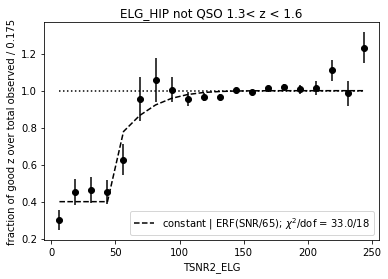

In [15]:
zmin = 1.3
zmax = 1.6
wgh = (arz['o2c'] > 0.9) | ((arz['ZWARN'] == 0) & (arz['Z'] > 1.55))
wa = arz['TSNR2_ELG'] != 1e20
wa &= arz['TSNR2_ELG'] != -99.0
wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['QSO']) == 0)
wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['ELG_HIP']) > 0)
wgh &= wa
wgh &= arz['Z'] > zmin
wgh &= arz['Z'] < zmax
ffo = arz[wa]
ffz = arz[wgh]
a = np.histogram(ffz['TSNR2_ELG'],bins=20,range=(0,250))
b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
fr = 0.175
ds = a[0]/b[0]/fr
es = np.sqrt(a[0])/b[0]/fr
bs = 250/20
plt.errorbar(a[1][:-1]+bs/2.,ds,es,fmt='ko')#,label=ps)#,fmt='ko')
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
el = erf(vs/65)
wl = vs < 45
lm = 0.4
el[wl] = lm
chi2 = np.sum(((ds-el)/es)**2.)
print(chi2)
plt.plot(vs,el,'k--',label='constant | ERF(SNR/65); $\chi^2$/dof = '+str(round(chi2,1))+'/18')
plt.plot(vs,ol,'k:')
plt.title('ELG_HIP not QSO '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_ELG')
plt.ylabel('fraction of good z over total observed / '+str(fr))
plt.legend(loc='lower right')
plt.show() 

### that chi2 is a bit worse and it looks like more of a trend from low to high tsnr, test other fit below

33.00933376635402
14.952979112686457


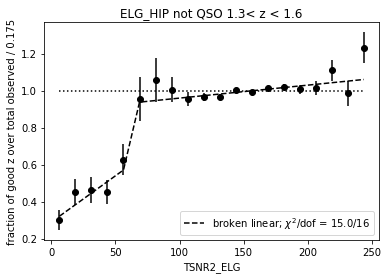

In [16]:
zmin = 1.3
zmax = 1.6
wgh = (arz['o2c'] > 0.9) | ((arz['ZWARN'] == 0) & (arz['Z'] > 1.55))
wa = arz['TSNR2_ELG'] != 1e20
wa &= arz['TSNR2_ELG'] != -99.0
wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['QSO']) == 0)
wa &= ((arz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['ELG_HIP']) > 0)
wgh &= wa
wgh &= arz['Z'] > zmin
wgh &= arz['Z'] < zmax
ffo = arz[wa]
ffz = arz[wgh]
a = np.histogram(ffz['TSNR2_ELG'],bins=20,range=(0,250))
b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
fr = 0.175
ds = a[0]/b[0]/fr
es = np.sqrt(a[0])/b[0]/fr
bs = 250/20
plt.errorbar(a[1][:-1]+bs/2.,ds,es,fmt='ko')#,label=ps)#,fmt='ko')
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
el = erf(vs/65)
wl = vs < 45
lm = 0.4
el[wl] = lm
chi2 = np.sum(((ds-el)/es)**2.)
el1 = 0.29+0.3/60.*vs
el2 = 0.89+0.07/100.*vs
wsp =  vs < 60
el2[wsp] = el1[wsp]
chi22 = np.sum(((ds-el2)/es)**2.)
print(chi2)
print(chi22)
plt.plot(vs,el2,'k--',label='broken linear; $\chi^2$/dof = '+str(round(chi22,1))+'/16')
plt.plot(vs,ol,'k:')
plt.title('ELG_HIP not QSO '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_ELG')
plt.ylabel('fraction of good z over total observed / '+str(fr))
plt.legend(loc='lower right')
plt.show() 

### so for the high redshift bin we can get a better fit with the linear model instead of ERF

(array([     0.,      0.,  35659., 141428.,  50761.,  22736.,  12404.,
          7136.,   4828.,   3283.,   2565.,   2162.,   1699.,   1350.,
          1280.,   1132.,   1192.,    916.,    850.,    719.]),
 array([0.   , 0.075, 0.15 , 0.225, 0.3  , 0.375, 0.45 , 0.525, 0.6  ,
        0.675, 0.75 , 0.825, 0.9  , 0.975, 1.05 , 1.125, 1.2  , 1.275,
        1.35 , 1.425, 1.5  ], dtype=float32),
 <a list of 20 Patch objects>)

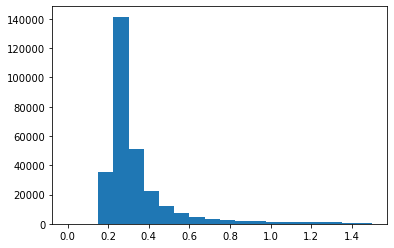

In [19]:
plt.hist(arz['FIBERFLUX_G'],bins=20,range=(0,1.5))

In [20]:
arz.columns

<TableColumns names=('TARGETID','CHI2','COEFF','Z','ZERR','ZWARN','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','NUMEXP','NUMTILE','PETAL_LOC','DEVICE_LOC','LOCATION','FIBER','FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','LAMBDA_REF','FA_TARGET','FA_TYPE','OBJTYPE','FIBERASSIGN_X','FIBERASSIGN_Y','PRIORITY','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKID','BRICK_OBJID','MORPHTYPE','FLUX_G','FLUX_R','FLUX_Z','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','MASKBITS','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','BRICKNAME','EBV','FLUX_W1','FLUX_W2','FLUX_IVAR_W1','FLUX_IVAR_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','SV3_DESI_TARGET','SV3_BGS_TARGET','SV3_MWS_TARGET','SV3_SCND_TARGET','TILEID','FN','HASCOADD','THRUNIGHT','FOII','FOII_ERR','GTOT','GFIB','GR','RZ','TSNR2_ELG_B','TS

306895
177041
306895
129854


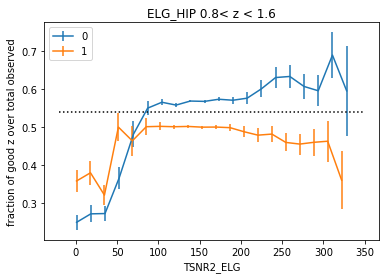

In [24]:
zmin = 0.8
zmax = 1.6
#for ps in ['N','S']:
for fm in [0,1]:
    wgh = (arz['o2c'] > 0.9) | ((arz['ZWARN'] == 0) & (arz['Z'] > 1.55))
    #wa = arz['LOCATION_ASSIGNED'] == 1
    wa = arz['TSNR2_ELG'] != 1e20
    wa &= arz['TSNR2_ELG'] != -99.0
    #wa &= arz['PHOTSYS'] == ps
    print(len(arz[wa]))
    if fm == 0:
        wa &= arz['FIBERFLUX_G'] < 0.3
    if fm == 1:
        wa &= arz['FIBERFLUX_G'] > 0.3
    print(len(arz[wa]))
    wgh &= wa
    wgh &= arz['Z'] > zmin
    wgh &= arz['Z'] < zmax
    ffo = arz[wa]
    ffz = arz[wgh]
    a = np.histogram(ffz['TSNR2_ELG'],bins=20)
    b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
    #plt.clf()
    plt.errorbar(a[1][:-1],a[0]/b[0],np.sqrt(a[0])/b[0],label=str(fm))#,fmt='ko')
vs = np.arange(-20,350,1)
ol = np.ones(len(vs))*0.54
plt.plot(vs,ol,'k:')
plt.title('ELG_HIP '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_ELG')
plt.ylabel('fraction of good z over total observed')
plt.legend(loc='upper left')
plt.show()   

In [23]:
dt = Table.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/dark_targets.fits')
dt.keep_columns(['TARGETID','MW_TRANSMISSION_G'])
arzj = join(arz,dt,keys=['TARGETID'],join_type='left')
print(len(arz),len(arzj))

307017 307017


306895
153043
306895
153852


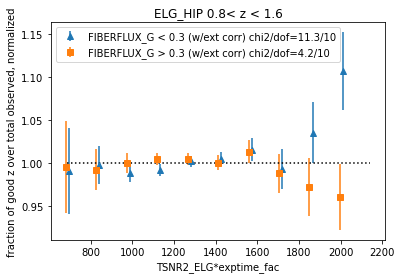

In [42]:
efac = 8.60
zmin = 0.8
zmax = 1.6
#for ps in ['N','S']:
fg = arz['FIBERFLUX_G']/arzj['MW_TRANSMISSION_G']
for fm in [0,1]:
    wgh = (arz['o2c'] > 0.9) | ((arz['ZWARN'] == 0) & (arz['Z'] > 1.55))
    #wa = arz['LOCATION_ASSIGNED'] == 1
    wa = arz['TSNR2_ELG'] != 1e20
    wa &= arz['TSNR2_ELG'] != -99.0
    #wa &= arz['PHOTSYS'] == ps
    print(len(arz[wa]))
    if fm == 0:
        wa &= fg < 0.3
        fr = .561
        lb = 'FIBERFLUX_G < 0.3 (w/ext corr)'
        ng = 7.5
        mt = '^'
    if fm == 1:
        wa &= fg > 0.3
        fr = .515
        lb = 'FIBERFLUX_G > 0.3 (w/ext corr)'
        ng = -7.5
        mt = 's'
    print(len(arz[wa]))
    wgh &= wa
    wgh &= arz['Z'] > zmin
    wgh &= arz['Z'] < zmax
    ffo = arz[wa]
    ffz = arz[wgh]
    a = np.histogram(ffz['TSNR2_ELG'],bins=10,range=(80,250))
    b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
    #plt.clf()
    dl = a[0]/b[0]/fr
    el = np.sqrt(a[0])/b[0]/fr
    chi2 = np.sum((dl-1.)**2./el**2.)
    plt.errorbar(a[1][:-1]*efac+ng,dl,el,label=lb+' chi2/dof='+str(round(chi2,1))+'/10',fmt=mt)#,fmt='ko')
vs = np.arange(80,250,1)
ol = np.ones(len(vs))#*0.54
plt.plot(vs*efac,ol,'k:')
plt.title('ELG_HIP '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_ELG*exptime_fac')
plt.ylabel('fraction of good z over total observed, normalized')
plt.legend(loc='upper left')
plt.show()  

In [36]:
wt = arz['TSNR2_ELG'] > 80
print(len(arz[wt]),len(arz),len(arz[wt])/len(arz))
lut = len(np.unique(arz[wt]['TARGETID']))
lu = len(np.unique(arz['TARGETID']))
print(lut,lu,lut/lu)

302630 307017 0.9857108889735747
243024 245996 0.9879185027398819


In [ ]:
zmin = 0.8
zmax = 1.6
#for ps in ['N','S']:
for fm in [0,1]:
    wgh = (arz['o2c'] > 0.9) | ((arz['ZWARN'] == 0) & (arz['Z'] > 1.55))
    #wa = arz['LOCATION_ASSIGNED'] == 1
    wa = arz['TSNR2_ELG'] != 1e20
    wa &= arz['TSNR2_ELG'] != -99.0
    #wa &= arz['PHOTSYS'] == ps
    print(len(arz[wa]))
    if fm == 0:
        wa &= arz['FIBERFLUX_G'] < 0.3
        fr = .57
        lb = 'FIBERFLUX_G < 0.3'
    if fm == 1:
        wa &= arz['FIBERFLUX_G'] > 0.3
        fr = .5
        lb = 'FIBERFLUX_G > 0.3'
    print(len(arz[wa]))
    wgh &= wa
    wgh &= arz['Z'] > zmin
    wgh &= arz['Z'] < zmax
    ffo = arz[wa]
    ffz = arz[wgh]
    a = np.histogram(ffz['TSNR2_ELG'],bins=20,range=(80,250))
    b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
    #plt.clf()
    plt.errorbar(a[1][:-1],a[0]/b[0]/fr,np.sqrt(a[0])/b[0]/fr,label=lb)#,fmt='ko')
vs = np.arange(-20,350,1)
ol = np.ones(len(vs))#*0.54
plt.plot(vs,ol,'k:')
plt.title('ELG_HIP '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_ELG')
plt.ylabel('fraction of good z over total observed, normalized')
plt.legend(loc='upper left')
plt.show()  